In [1]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import nltk
import textstat
#nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from textstat.textstat import textstat
from matplotlib.table import Table
from scipy.stats import multivariate_normal, invwishart
from abc import ABC, abstractmethod
%matplotlib inline

In [2]:
df = pd.read_csv('raw_dataset - Sheet3.csv')
test_df = pd.read_csv('exp_test.csv')

In [3]:
df

,index,title,author,text,publisher,datepublished,link
0,1,The Marcoses' three-body problem,John Nery,The success of the Marcos-Duterte electoral al...,Rappler,4/1/2024,https://www.rappler.com/voices/thought-leaders...
1,2,State of the opposition: Worth dying for,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,Rappler,8/30/2022,https://www.rappler.com/voices/thought-leaders...
2,3,Elon Musk and magical thinking,John Nery,One of many lessons from the ongoing Twitter f...,Rappler,11/25/2022,https://www.rappler.com/voices/thought-leaders...
3,4,So what's wrong with Marcos's F1 party?,John Nery,Of course we all need to be particular about t...,Rappler,10/06/2022,https://www.rappler.com/voices/thought-leaders...
4,5,Patricia Evangelista and writing the war,John Nery,"In 'Some People Need Killing,' the acclaimed j...",Rappler,10/18/2023,https://www.rappler.com/life-and-style/literat...
5,6,What do we do about Alice Guo,John Nery,The answers she gave in two Senate hearings we...,Rappler,05/29/2024,https://www.rappler.com/voices/thought-leaders...
6,7,The media is not the press,John Nery,Confusing one with the other allows disinforma...,Rappler,04/13/2024,https://www.rappler.com/voices/thought-leaders...
7,8,The paradoxical pope,John Nery,The complicated but lasting legacy of Benedict...,Rappler,01/04/2023,https://www.rappler.com/voices/thought-leaders...
8,9,What's next for VP Sara: Go Macapagal or go Ar...,John Nery,Now that she has passed the point of no return...,Rappler,05/21/2024,https://www.rappler.com/voices/thought-leaders...
9,10,Time to negotiate peace again with the CPP-NPA,John Nery,The communist insurgency is at its weakest. Co...,Rappler,05/11/2024,https://www.rappler.com/voices/thought-leaders...


In [4]:
test_df

,index,text,label
0,1,"""In the aftermath of Carlos Yulo’s historic an...",0
1,2,"""I had never been as excited monitoring the Ol...",0
2,3,"""Listed property developer Megaworld Corp. on ...",0
3,4,"""Our golden boy Carlos Yulo made history on Su...",0
4,5,"""This is not just a win for Carlos Yulo.\r\n\r...",0
5,6,"""Filipino gymnastics star Carlos Yulo has seen...",0
6,7,"""Team Philippines gymnast Carlos Yulo is set f...",0
7,8,"""Rewards are still pouring in for Filipino Oly...",0
8,9,"""When he comes home, gold medalist Carlos Yulo...",0
9,10,"""CARLOS Yulo received another P10 million wind...",0


In [5]:
def preprocess_text(text):
    # Convert to lowercase
    return text.lower()

# Helper function to calculate complex sentence ratio
def count_clauses(sentence):
    # A simple approximation using commas, semicolons, and conjunctions
    return sentence.count(',') + sentence.count(';') + sentence.lower().count('and') + sentence.lower().count('but')

# Feature extraction function
def extract_features(text):
    # Tokenize words and sentences
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    # Basic metrics
    word_count = len([word for word in words if word.isalpha()])
    avg_word_length = np.mean([len(word) for word in words if word.isalpha()]) if word_count > 0 else 0
    avg_sentence_length = word_count / len(sentences) if len(sentences) > 0 else 0

    # Punctuation metrics
    punctuation_count = sum(1 for char in text if char in ['.', ',', ':', ';', '?', '!', '-', '\'', '\"'])
    punctuation_ratio = punctuation_count / word_count if word_count > 0 else 0
    avg_punctuation_per_sentence = punctuation_count / len(sentences) if len(sentences) > 0 else 0

    # Linguistic diversity features
    vocab_size = len(set([word for word in words if word.isalpha()]))
    vocab_ratio = vocab_size / word_count if word_count > 0 else 0

    # Readability metrics
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    smog_index = textstat.smog_index(text)
    cl_index = textstat.coleman_liau_index(text)

    # Sentence complexity metrics
    total_clauses = sum(count_clauses(sentence) for sentence in sentences)
    avg_clauses_per_sentence = total_clauses / len(sentences) if len(sentences) > 0 else 0
    complex_sentence_ratio = sum(1 for sentence in sentences if count_clauses(sentence) > 1) / len(sentences) if len(sentences) > 0 else 0

    # Lexical density
    pos_tags = pos_tag(words)
    content_words = [word for word, pos in pos_tags if pos.startswith(('NN', 'VB', 'JJ', 'RB'))]
    lexical_density = len(content_words) / word_count if word_count > 0 else 0

    return {
        'word_count': word_count,
        'sentence_count': len(sentences),
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'punctuation_count': punctuation_count,
        'punctuation_ratio': punctuation_ratio,
        'avg_punctuation_per_sentence': avg_punctuation_per_sentence,
        'vocab_size': vocab_size,
        'vocab_ratio': vocab_ratio,
        'flesch_reading_ease': flesch_reading_ease,
        'gunning_fog': gunning_fog,
        'smog_index': smog_index,
        'coleman_liau_index': cl_index,
        'avg_clauses_per_sentence': avg_clauses_per_sentence,
        'complex_sentence_ratio': complex_sentence_ratio,
        'lexical_density': lexical_density
    }

# Apply preprocessing and feature extraction to each text sample
def preprocess_and_extract_features(df):
    df['preprocessed_text'] = df['text'].apply(preprocess_text)
    df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
    return pd.concat([df[['index', 'label']], df_features], axis=1)

In [6]:
#Apply preprocessing and feature extraction to each text sample
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
df = pd.concat([df, df_features], axis=1)

In [7]:
# Model training
X = df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
y = df['author']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [8]:
# Model Preparation
X_test = test_df.drop(['index', 'label'], axis=1)
y_test = test_df['label']

In [9]:
def classify_new_text(new_text, model):
    # Preprocess the text and extract features
    preprocessed_text = preprocess_text(new_text)
    new_features = extract_features(preprocessed_text)
    new_features_df = pd.DataFrame([new_features])

    # Reindex using the cleaned X_train's columns
    new_features_df = new_features_df.reindex(columns=X_train.columns)

    # Handle any NaN values
    new_features_df = new_features_df.fillna(0)

    # Predict the author
    predicted_author = model.predict(new_features_df)
    return predicted_author[0]

In [10]:
# Function to extract features and store them into a DataFrame
def extract_features_as_df(text):
    # Call the existing extract_features function
    raw_features = extract_features(text)
    
    # Convert the features to a DataFrame with two columns: Feature and Value
    features_df = pd.DataFrame(list(raw_features.items()), columns=['Feature', 'Value'])
    
    return features_df

def extract_features_for_csv(df):
    feature_dfs = df['text'].apply(extract_features_as_df)
    
    # Concatenate all the feature DataFrames into a single DataFrame
    all_features = pd.concat(feature_dfs.tolist(), ignore_index=True)
    
    # Concatenate the extracted features with the original DataFrame
    df_features = pd.concat([df, all_features], axis=1)
    
    # Remove rows with any NaN values
    df_features_cleaned = df_features.dropna()
    
    return df_features_cleaned

df_features = extract_features_for_csv(df)
df_features

,index,title,author,text,publisher,datepublished,link,preprocessed_text,word_count,sentence_count,...,vocab_ratio,flesch_reading_ease,gunning_fog,smog_index,coleman_liau_index,avg_clauses_per_sentence,complex_sentence_ratio,lexical_density,Feature,Value
0,1.0,The Marcoses' three-body problem,John Nery,The success of the Marcos-Duterte electoral al...,Rappler,4/1/2024,https://www.rappler.com/voices/thought-leaders...,the success of the marcos-duterte electoral al...,1558.0,65.0,...,0.391528,47.32,13.13,13.8,11.78,2.000000,0.523077,0.620668,word_count,1558.000000
1,2.0,State of the opposition: Worth dying for,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,Rappler,8/30/2022,https://www.rappler.com/voices/thought-leaders...,the war on ninoy aquino’s legacy is a fight th...,1475.0,56.0,...,0.395932,54.66,13.13,13.4,11.09,2.589286,0.625000,0.608136,sentence_count,68.000000
2,3.0,Elon Musk and magical thinking,John Nery,One of many lessons from the ongoing Twitter f...,Rappler,11/25/2022,https://www.rappler.com/voices/thought-leaders...,one of many lessons from the ongoing twitter f...,851.0,39.0,...,0.453584,67.28,11.03,11.1,10.21,2.256410,0.487179,0.642773,avg_word_length,4.835045
3,4.0,So what's wrong with Marcos's F1 party?,John Nery,Of course we all need to be particular about t...,Rappler,10/06/2022,https://www.rappler.com/voices/thought-leaders...,of course we all need to be particular about t...,996.0,40.0,...,0.391566,57.20,12.12,13.1,10.51,2.175000,0.600000,0.648594,avg_sentence_length,22.911765
4,5.0,Patricia Evangelista and writing the war,John Nery,"In 'Some People Need Killing,' the acclaimed j...",Rappler,10/18/2023,https://www.rappler.com/life-and-style/literat...,"in 'some people need killing,' the acclaimed j...",1800.0,73.0,...,0.402222,59.53,11.04,11.8,10.68,2.808219,0.561644,0.655000,punctuation_count,179.000000
5,6.0,What do we do about Alice Guo,John Nery,The answers she gave in two Senate hearings we...,Rappler,05/29/2024,https://www.rappler.com/voices/thought-leaders...,the answers she gave in two senate hearings we...,1782.0,69.0,...,0.415825,47.22,13.67,13.6,11.03,2.753623,0.594203,0.635802,punctuation_ratio,0.114891
6,7.0,The media is not the press,John Nery,Confusing one with the other allows disinforma...,Rappler,04/13/2024,https://www.rappler.com/voices/thought-leaders...,confusing one with the other allows disinforma...,1626.0,71.0,...,0.378844,59.03,11.64,12.8,10.91,2.225352,0.619718,0.642681,avg_punctuation_per_sentence,2.632353
7,8.0,The paradoxical pope,John Nery,The complicated but lasting legacy of Benedict...,Rappler,01/04/2023,https://www.rappler.com/voices/thought-leaders...,the complicated but lasting legacy of benedict...,1454.0,40.0,...,0.409904,41.74,15.95,14.9,11.96,3.925000,0.625000,0.646492,vocab_size,644.000000
8,9.0,What's next for VP Sara: Go Macapagal or go Ar...,John Nery,Now that she has passed the point of no return...,Rappler,05/21/2024,https://www.rappler.com/voices/thought-leaders...,now that she has passed the point of no return...,1253.0,45.0,...,0.420591,57.50,12.09,13.2,11.02,2.377778,0.533333,0.610535,vocab_ratio,0.413350
9,10.0,Time to negotiate peace again with the CPP-NPA,John Nery,The communist insurgency is at its weakest. Co...,Rappler,05/11/2024,https://www.rappler.com/voices/thought-leaders...,the communist insurgency is at its weakest. co...,1400.0,48.0,...,0.423571,36.32,15.39,16.2,13.81,2.791667,0.562500,0.685714,flesch_reading_ease,47.320000


In [11]:
# Feature normalization ranges
feature_ranges = {
    'word_count': (0, 10000),  # Adjust as needed
    'sentence_count': (0, 1000),  # Adjust as needed
    'avg_word_length': (1, 10),  # Average word length typically ranges from 1 to 10 characters
    'avg_sentence_length': (0, 100),  # Average sentence length in words
    'punctuation_count': (0, 1000),  # Total punctuation marks, adjust as needed
    'punctuation_ratio': (0, 1),  # Ratio of punctuation marks per character
    'avg_punctuation_per_sentence': (0, 10),  # Adjust based on expected punctuation per sentence
    'vocab_size': (0, 1000),  # Vocabulary size, adjust as needed
    'vocab_ratio': (0, 1),  # Vocabulary ratio
    'flesch_reading_ease': (0, 100),  # Flesch reading ease score
    'gunning_fog': (6, 17),  # Gunning-Fog Index
    'smog_index': (6, 17),  # SMOG Index
    'coleman_liau_index': (5, 17),  # Coleman-Liau Index
    'avg_clauses_per_sentence': (0, 10),  # Average number of clauses per sentence
    'complex_sentence_ratio': (0, 1),  # Ratio of complex sentences
    'lexical_density': (0, 1)  # Lexical density
}

def normalize_feature(value, feature_name, feature_ranges):
    """Normalize a single feature value based on its predefined range."""
    if feature_name in feature_ranges:
        min_val, max_val = feature_ranges[feature_name]
        if max_val - min_val == 0:  # Avoid division by zero
            return 0
        return (value - min_val) / (max_val - min_val)
    else:
        raise ValueError(f"Feature '{feature_name}' does not have defined normalization ranges.")

def extract_and_normalize_features_as_df(text, feature_ranges):
    """Extract features, normalize them, and return as a DataFrame with normalized columns."""
    # Extract features into a DataFrame
    features_df = extract_features_as_df(text)

    # Check for empty or missing data
    if features_df.empty:
        print("No features extracted for the text. Returning an empty DataFrame.")
        return pd.DataFrame()  # Return an empty DataFrame for consistency

    # Create a dictionary to store normalized values
    normalized_data = {}

    for _, row in features_df.iterrows():
        feature_name = row['Feature']
        raw_value = row['Value']

        if feature_name in feature_ranges:
            # Normalize the feature value and add it as a new column
            normalized_data[f"{feature_name}_normalized"] = normalize_feature(raw_value, feature_name, feature_ranges)
        else:
            print(f"Feature '{feature_name}' not found in feature_ranges. Skipping normalization.")

    # Convert normalized data to a DataFrame
    normalized_df = pd.DataFrame([normalized_data])
    return normalized_df

def extract_and_normalize_features_for_csv(df, feature_ranges):
    """Extract and normalize features for the entire dataset."""
    # Initialize a list to store normalized DataFrames for each text
    normalized_dfs = []

    for text in df['text']:
        normalized_df = extract_and_normalize_features_as_df(text, feature_ranges)
        normalized_dfs.append(normalized_df)

    # Concatenate all normalized DataFrames into a single DataFrame
    all_normalized_features = pd.concat(normalized_dfs, ignore_index=True)

    # Add the normalized columns to the original DataFrame
    df_features = pd.concat([df.reset_index(drop=True), all_normalized_features.reset_index(drop=True)], axis=1)

    # Drop rows with NaN values if any normalized feature is missing
    df_features_cleaned = df_features.dropna()

    return df_features_cleaned

In [12]:
# Extract and normalize features for the dataset
df_normalized_features = extract_and_normalize_features_for_csv(df, feature_ranges)

# Display the normalized DataFrame
df_normalized_features

,index,title,author,text,publisher,datepublished,link,preprocessed_text,word_count,sentence_count,...,avg_punctuation_per_sentence_normalized,vocab_size_normalized,vocab_ratio_normalized,flesch_reading_ease_normalized,gunning_fog_normalized,smog_index_normalized,coleman_liau_index_normalized,avg_clauses_per_sentence_normalized,complex_sentence_ratio_normalized,lexical_density_normalized
0,1,The Marcoses' three-body problem,John Nery,The success of the Marcos-Duterte electoral al...,Rappler,4/1/2024,https://www.rappler.com/voices/thought-leaders...,the success of the marcos-duterte electoral al...,1558.0,65.0,...,0.263235,0.644,0.413350,0.4732,0.648182,0.709091,0.565000,0.191176,0.529412,0.616816
1,2,State of the opposition: Worth dying for,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,Rappler,8/30/2022,https://www.rappler.com/voices/thought-leaders...,the war on ninoy aquino’s legacy is a fight th...,1475.0,56.0,...,0.310714,0.615,0.416949,0.5466,0.648182,0.672727,0.507500,0.258929,0.625000,0.604746
2,3,Elon Musk and magical thinking,John Nery,One of many lessons from the ongoing Twitter f...,Rappler,11/25/2022,https://www.rappler.com/voices/thought-leaders...,one of many lessons from the ongoing twitter f...,851.0,39.0,...,0.292500,0.409,0.480611,0.6728,0.457273,0.463636,0.434167,0.220000,0.475000,0.643948
3,4,So what's wrong with Marcos's F1 party?,John Nery,Of course we all need to be particular about t...,Rappler,10/06/2022,https://www.rappler.com/voices/thought-leaders...,of course we all need to be particular about t...,996.0,40.0,...,0.272500,0.412,0.413655,0.5720,0.556364,0.645455,0.459167,0.217500,0.600000,0.649598
4,5,Patricia Evangelista and writing the war,John Nery,"In 'Some People Need Killing,' the acclaimed j...",Rappler,10/18/2023,https://www.rappler.com/life-and-style/literat...,"in 'some people need killing,' the acclaimed j...",1800.0,73.0,...,0.375342,0.769,0.427222,0.5953,0.458182,0.527273,0.473333,0.280822,0.561644,0.653889
5,6,What do we do about Alice Guo,John Nery,The answers she gave in two Senate hearings we...,Rappler,05/29/2024,https://www.rappler.com/voices/thought-leaders...,the answers she gave in two senate hearings we...,1782.0,69.0,...,0.335714,0.779,0.437149,0.4722,0.697273,0.690909,0.502500,0.271429,0.571429,0.636925
6,7,The media is not the press,John Nery,Confusing one with the other allows disinforma...,Rappler,04/13/2024,https://www.rappler.com/voices/thought-leaders...,confusing one with the other allows disinforma...,1626.0,71.0,...,0.307042,0.655,0.402829,0.5903,0.512727,0.618182,0.492500,0.222535,0.619718,0.634686
7,8,The paradoxical pope,John Nery,The complicated but lasting legacy of Benedict...,Rappler,01/04/2023,https://www.rappler.com/voices/thought-leaders...,the complicated but lasting legacy of benedict...,1454.0,40.0,...,0.416667,0.621,0.427098,0.4174,0.904545,0.809091,0.580000,0.373810,0.642857,0.643741
8,9,What's next for VP Sara: Go Macapagal or go Ar...,John Nery,Now that she has passed the point of no return...,Rappler,05/21/2024,https://www.rappler.com/voices/thought-leaders...,now that she has passed the point of no return...,1253.0,45.0,...,0.296000,0.550,0.438947,0.5750,0.553636,0.654545,0.501667,0.214000,0.520000,0.612131
9,10,Time to negotiate peace again with the CPP-NPA,John Nery,The communist insurgency is at its weakest. Co...,Rappler,05/11/2024,https://www.rappler.com/voices/thought-leaders...,the communist insurgency is at its weakest. co...,1400.0,48.0,...,0.330612,0.624,0.445714,0.3632,0.853636,0.927273,0.734167,0.273469,0.571429,0.685000


In [13]:
# Function to extract stylometric features for BOCPD
def extract_stylometric_features_for_bocpd(new_text):
    preprocessed_text = preprocess_text(new_text)
    features = extract_features(preprocessed_text)
    return features

In [14]:
# Hazard function
def constant_hazard(lam, t):
    return 1 / lam

# Predictive model (Gaussian)
class MultivariateGaussianPredictiveModel:
    def __init__(self, mu0, kappa0=1, alpha0=1, beta0=None):
        # mu0 is a vector for the mean of the prior
        # beta0 is a matrix for the covariance of the prior
        self.mu0 = np.array(mu0)
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0 if beta0 is not None else np.eye(len(mu0))  # Identity matrix if not provided
        
        # Initialize posterior parameters
        self.mu = np.array(mu0)
        self.kappa = kappa0
        self.alpha = alpha0
        self.beta = np.array(self.beta0)

    def update(self, x):
        x = np.array(x)
        self.kappa += 1
        self.mu = (self.kappa * self.mu0 + x) / (self.kappa + 1)
        diff = x - self.mu0
        self.beta += 0.5 * np.outer(diff, diff)  # Update covariance
        self.alpha += 0.5

    def log_predictive(self, x):
        d = len(self.mu0)  # Dimensionality
        x = np.array(x)

        # Covariance matrix for predictive distribution
        cov_matrix = (self.beta * (self.kappa + 1)) / (self.alpha * self.kappa)
    
        # Regularize the covariance matrix
        cov_matrix += np.eye(d) * 1e-6  # Add small value to diagonal

        try:
            cov_det = np.linalg.det(cov_matrix)
            cov_inv = np.linalg.inv(cov_matrix)

            # Multivariate Gaussian log probability
            log_prob = -0.5 * d * np.log(2 * np.pi) - 0.5 * np.log(cov_det) - \
                       0.5 * np.dot((x - self.mu).T, np.dot(cov_inv, (x - self.mu)))
            return log_prob
        except np.linalg.LinAlgError:
            print("Covariance matrix is singular. Returning -inf for log probability.")
            return -np.inf  # Return a very low log probability

# Bayesian Online Change Point Detection algorithm
def bocpd(data, hazard_func, predictive_model):
    T = len(data)
    P = np.zeros((T+1, T+1))
    P[0, 0] = 1
    
    max_run_length = []
    
    for t in range(1, T+1):
        hazard = hazard_func(t)
        log_pred_prob = np.array([predictive_model.log_predictive(data[t-1]) for _ in range(t)])
        P[t, 1:t+1] = P[t-1, :t] * np.exp(log_pred_prob) * (1 - hazard)
        P[t, 0] = np.sum(P[t-1, :t] * hazard)
        P[t, :t+1] /= np.sum(P[t, :t+1])
        predictive_model.update(data[t-1])
        max_run_length.append(np.argmax(P[t, :t+1]))
    
    return P, max_run_length

# Detect change points
def detect_change_points(run_length_probs):
    change_points = []
    for t, prob in enumerate(run_length_probs):
        if prob == 0:  # Run length resets, indicating a change
            change_points.append(t)
    return change_points


In [15]:
def display_table_with_white_background(dataframe, title):
    # Round numeric values to 2 decimal places
    dataframe = dataframe.round(2)

    fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size as needed
    ax.axis('off')

    table = Table(ax, bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # This will set the default font size for the table

    # Set column width and cell height
    col_width = 1.5
    row_height = 0.4
    num_rows, num_cols = dataframe.shape

    # Add table headers
    for i, column in enumerate(dataframe.columns):
        cell = table.add_cell(0, i, width=col_width, height=row_height, text=column, loc='center', facecolor='white', edgecolor='black')
        cell._text.set_fontsize(12)  # Set font size for header

    # Add table data
    for i, row in dataframe.iterrows():
        for j, value in enumerate(row):
            cell = table.add_cell(i + 1, j, width=col_width, height=row_height, text=f"{value:.2f}" if isinstance(value, (int, float)) else value, loc='center', facecolor='white', edgecolor='black')
            cell._text.set_fontsize(10)  # Set font size for data

    ax.add_table(table)
    plt.title(title, fontsize=14, pad=20)
    plt.show()

In [16]:
def detect_change_points_in_text(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features = extract_features(preprocess_text(new_text))
    
    features_df = pd.DataFrame([features])
    features_df = features_df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
    
    predicted_author = trained_model.predict(features_df)
    
    if predicted_author[0] != author:
        print(f"Warning: The provided author does not match the predicted author. Using provided author '{author}' for analysis.")
    
    # Extract stylometric features for each sentence
    sentences = sent_tokenize(new_text)
    sentence_features = []
    
    for sentence in sentences:
        preprocessed_sentence = preprocess_text(sentence)
        sentence_feature = extract_features(preprocessed_sentence)
        
        selected_features = [
            sentence_feature['avg_word_length'], 
            sentence_feature['avg_sentence_length'], 
            sentence_feature['punctuation_ratio'], 
            sentence_feature['vocab_ratio'],
            sentence_feature['flesch_reading_ease'],
            sentence_feature['gunning_fog'],
            sentence_feature['smog_index'],
            sentence_feature['coleman_liau_index'],
            sentence_feature['avg_clauses_per_sentence'],
            sentence_feature['complex_sentence_ratio'],
            sentence_feature['lexical_density']
        ]
        sentence_features.append(selected_features)
    
    sentence_features = np.array(sentence_features)
    
    # Initialize BOCPD model for multivariate data
    hazard_func = lambda t: constant_hazard(250, t)
    initial_mean = np.mean(sentence_features, axis=0)
    initial_covariance = np.cov(sentence_features, rowvar=False)  # Initial covariance matrix
    
    predictive_model = MultivariateGaussianPredictiveModel(mu0=initial_mean, beta0=initial_covariance)
    
    # Run BOCPD on all selected features (multivariate analysis)
    P, max_run_length = bocpd(sentence_features, hazard_func, predictive_model)

    # Detect change points
    changepoints = detect_change_points(max_run_length)

    feature_categories = {
        'Phraseology': ['avg_word_length', 'avg_sentence_length', 'avg_clauses_per_sentence'],
        'Punctuation': ['punctuation_ratio'],
        'Linguistic Diversity': ['vocab_ratio', 'lexical_density', 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index', 'complex_sentence_ratio'],
        # 'readability': ['flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index'],
        # 'complexity': ['complex_sentence_ratio']
    }

    explanations = []
    changepoint_data = [] #List to collect data for DataFrame
    
    # Initialize counters for category changes
    category_changes = {category: set() for category in feature_categories.keys()}
    total_changes = {category: 0 for category in feature_categories.keys()}
    
    for idx in changepoints:
        if idx > 0 and idx < len(sentences):
            prev_features = sentence_features[idx - 1]
            curr_features = sentence_features[idx]
            
            feature_changes = []
            for i, feature_name in enumerate(
                ['avg_word_length', 'avg_sentence_length', 'punctuation_ratio', 'vocab_ratio',
                 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
                 'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']):
                
                change = curr_features[i] - prev_features[i]
                
                # Only include positive changes
                if change > 0:  # Process only non-zero changes
                    category = next((cat for cat, features in feature_categories.items() if feature_name in features), None)
    
                    if category:
                        category_changes[category].add(idx)
    
                        # Normalize change and ensure non-negative value
                        normalized_change = max(normalize_feature(change, feature_name, feature_ranges), 0)
    
                        feature_changes.append({
                            'Feature': feature_name,
                            'Change Value': normalized_change,  # Always non-negative
                            'Category': category
                        })
                        
                        # Add row to changepoint data
                        changepoint_data.append({
                            'Sentence Index': idx,
                            'Sentence': sentences[idx],
                            'Feature': feature_name,
                            'Change Value': change,
                            'Category': category
                        })
       
           
            if feature_changes:  # Only add explanations if there are valid positive changes
                explanation = {
                    'sentence': sentences[idx],
                    'feature_changes': feature_changes
                }
                explanations.append(explanation)

    # Create DataFrame from collected changepoint data
    changepoint_df = pd.DataFrame(changepoint_data)
    
    # Display summary of changes by category
    print("\n--- Percentage of Change by Category ---")
    total_sentences = len(sentences)
    for category, sentence_indices in category_changes.items():
        unique_changes = len(sentence_indices)
        category_percentage = (unique_changes / total_sentences) * 100 if total_sentences > 0 else 0
        print(f"{category.capitalize()}: {category_percentage:.2f}% change detected out of {total_sentences} sentences.")
    
    # Display results similarly
    for explanation in explanations:
        print(f"Change detected in sentence: {explanation['sentence']}")
        print("Feature changes:")
        
        table_data = []
        for feature_change in explanation['feature_changes']:
            table_data.append([
                feature_change['Feature'],
                feature_change['Change Value'],
                feature_change['Category']
            ])
        
        change_table = pd.DataFrame(table_data, columns=[
            'Feature', 'Change Value', 'Category'
        ])
        display_table_with_white_background(change_table, "Change Point Detection of Features for this Sentence")

    # print("\n--- Percentage of Change by Category ---")
    # for category, changes in category_changes.items():
    #     total_sentences = len(sentences)
    #     category_percentage = (changes / total_sentences) * 100 if total_sentences > 0 else 0
    #     print(f"{category.capitalize()}: {category_percentage:.2f}% change detected out of {total_sentences} sentences.")

    return changepoints, explanations, changepoint_df


In [17]:
def detect_change_points_in_text_with_normalization(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features_df = extract_features_as_df(preprocess_text(new_text))
    
    # Normalize the feature values
    normalized_features_df = normalize_features(features_df)
    
    print("Features with Normalized Values:")
    display(normalized_features_df)
    
    # Use normalized values in further computations
    normalized_features = normalized_features_df['Normalized Value'].values
    
    # Perform changepoint detection using normalized features
    # (Insert the existing BOCPD changepoint detection logic here)
    # Ensure all calculations use the normalized_features array

    return normalized_features_df



--- Percentage of Change by Category ---
Phraseology: 41.86% change detected out of 43 sentences.
Punctuation: 25.58% change detected out of 43 sentences.
Linguistic diversity: 44.19% change detected out of 43 sentences.
Change detected in sentence: If true, being non-Filipino made it worse, many times over.
Feature changes:


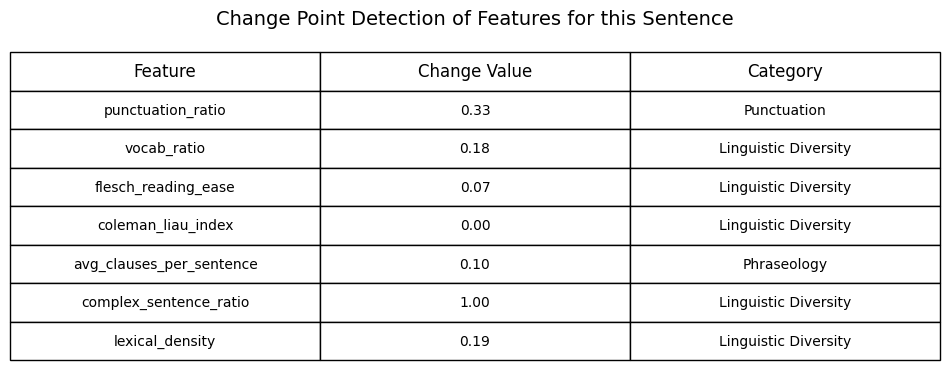

Change detected in sentence: Of course, no less disrespectful of the law is how Apollo Quiboloy broke it by refusing to surrender to the authorities, until recently, despite the arrest warrant served to him in his own kingdom.
Feature changes:


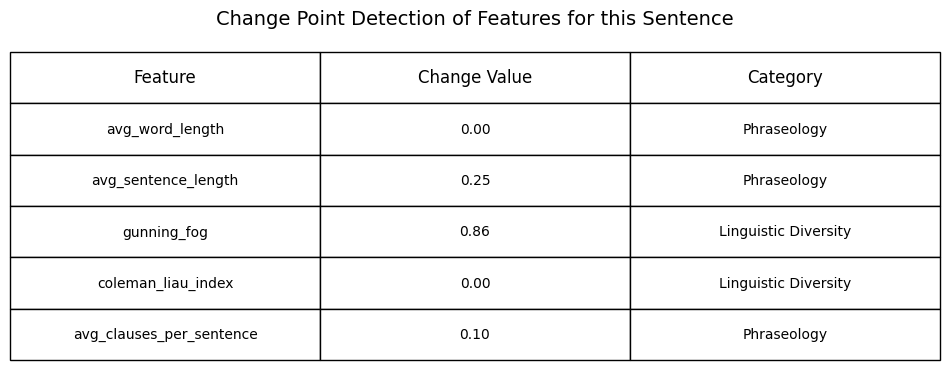

Change detected in sentence: Unfortunately, disrespect of the law, rather than the rule of law, has a long history in the Philippines.
Feature changes:


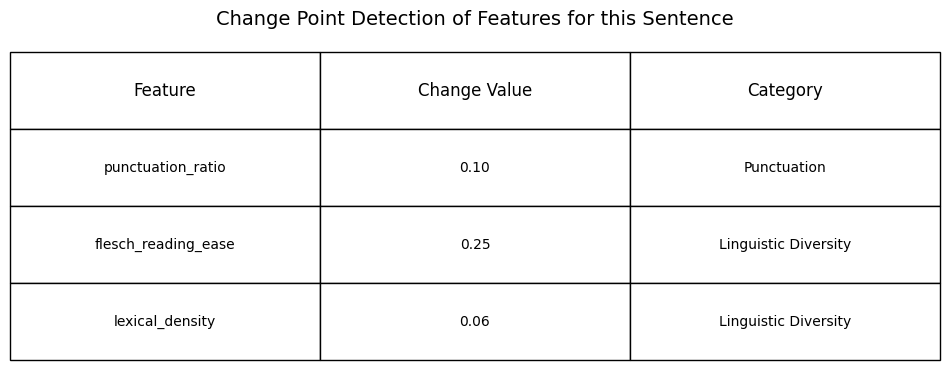

Change detected in sentence: The American expatriate businessman Harry Stonehill broke the law when he bribed high-level government officials in the early 1960s.
Feature changes:


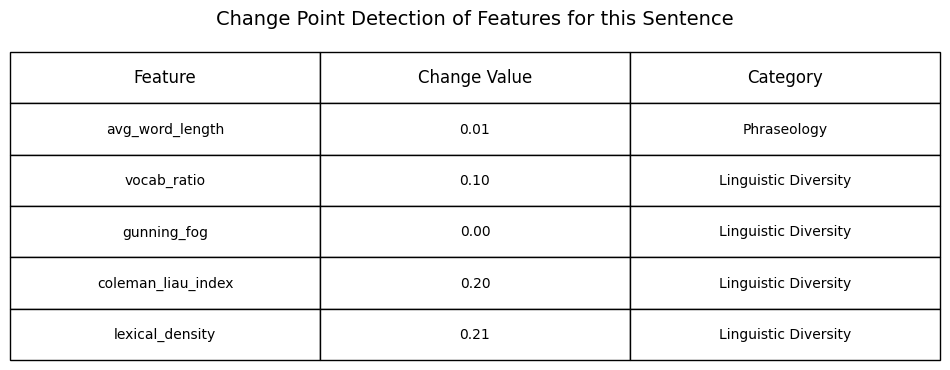

Change detected in sentence: Then Justice Secretary Jose W. Diokno caused the raid of the offices of 42 of Stonehill’s business establishments in 1962 and the arrest of Stonehill and some of his associates.
Feature changes:


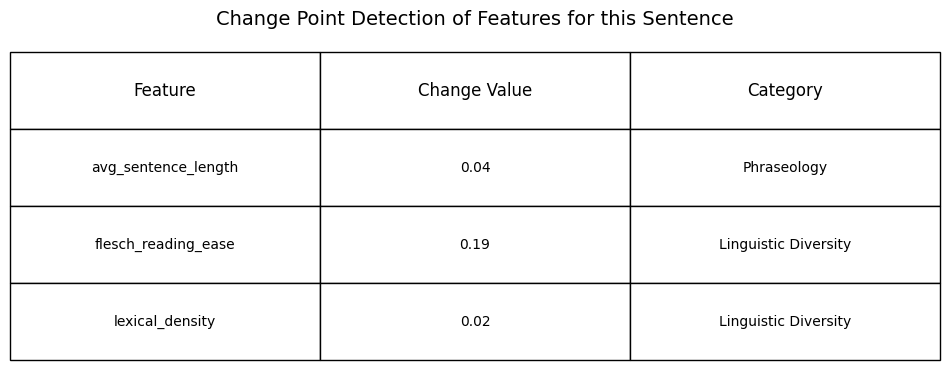

Change detected in sentence: Based on what was described as six army trucks worth of incriminating evidence, Stonehill was accused of tax evasion, economic sabotage, and various other charges that could have been established by his Blue Book which mysteriously went missing.
Feature changes:


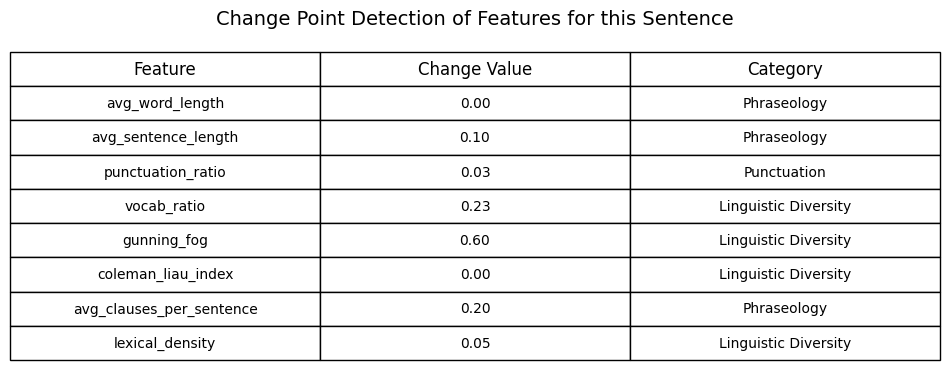

Change detected in sentence: If she is indeed non-Filipino and therefore disqualified, she violated our electoral law when she ran and took her oath of office as mayor of Bamban, Tarlac.
Feature changes:


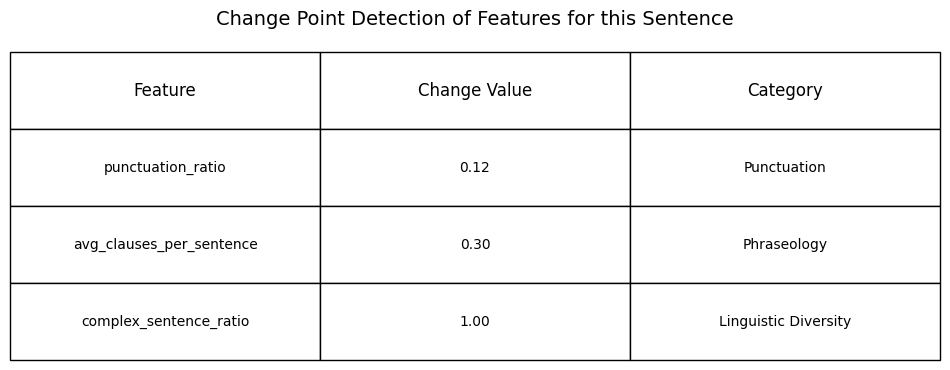

Change detected in sentence: It was impossible because her tax returns and SALN could only support a modest lifestyle.
Feature changes:


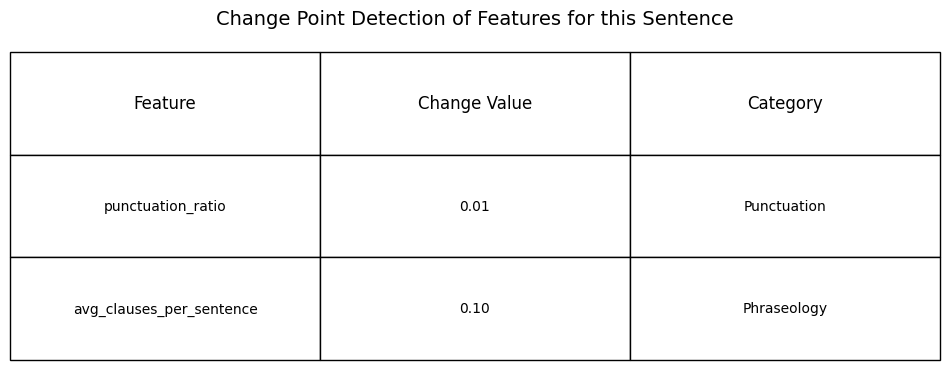

Change detected in sentence: As Reuters reported, even as Philippine authorities had filed several counts of money laundering, Guo continues to insist “she is natural-born Philippine citizen facing ‘malicious accusations,’ and had no knowledge of criminality.” This is strange because she could not even remember her roots, even her playmates while growing up.
Feature changes:


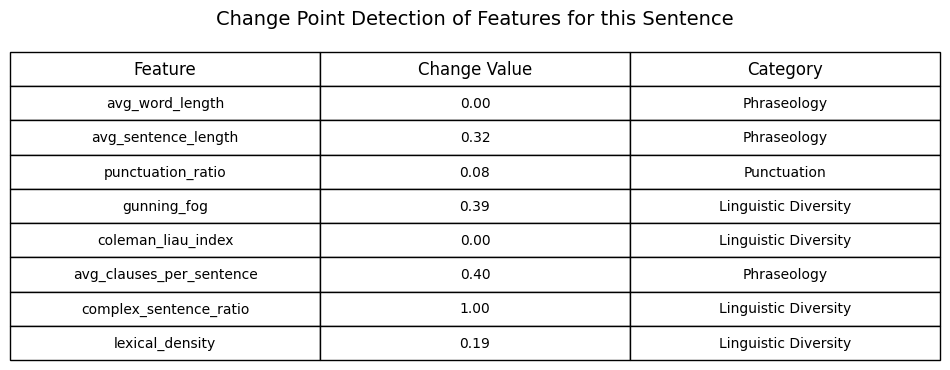

Change detected in sentence: For weeks before she escaped from the Philippines to Malaysia, Singapore and Indonesia, our elected senators could not get through her.
Feature changes:


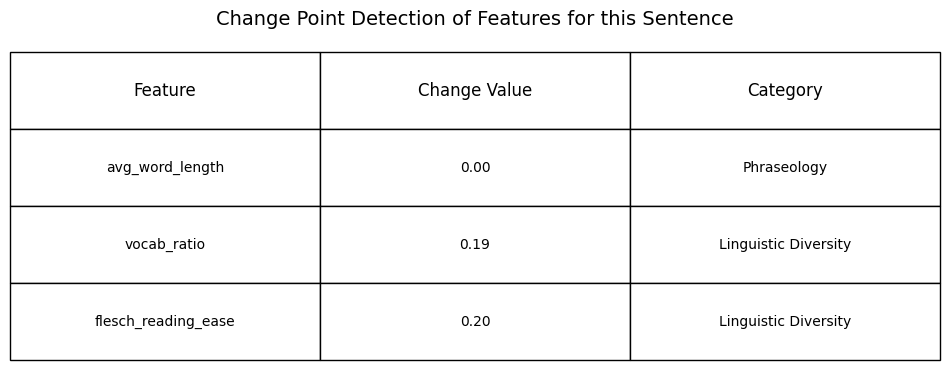

Change detected in sentence: It was a blank wall for them when Guo would always retort that she grew up in a farm, her only close friends were the farmhands in their piggery, or when confronted by documentary evidence of her true nationality, that she could not remember anymore.
Feature changes:


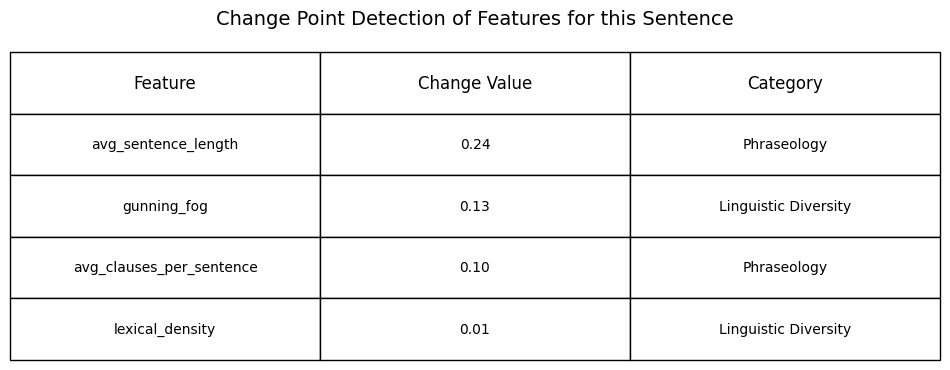

Change detected in sentence: The bigger picture is the undeniable involvement of those in authority.
Feature changes:


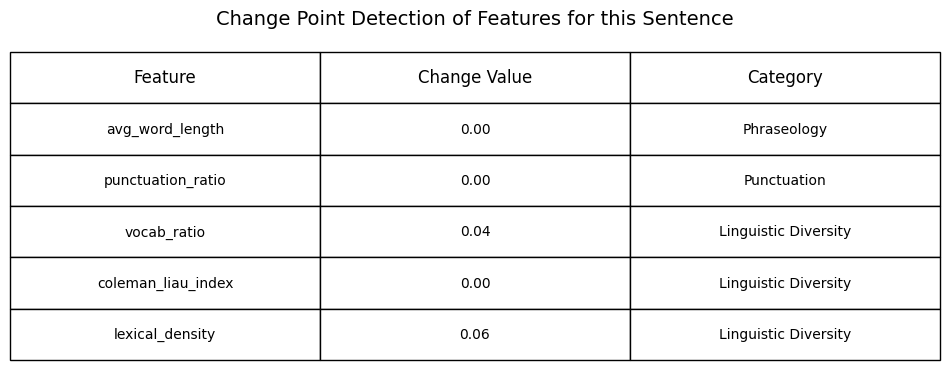

Change detected in sentence: As Rappler reported, a lawyer “committed lapses when he notarized the counter-affidavit of suspended Bamban Mayor Alice Guo in relation to a DOJ human trafficking complaint on Aug. 14.” By that time, Guo was already out of the country.
Feature changes:


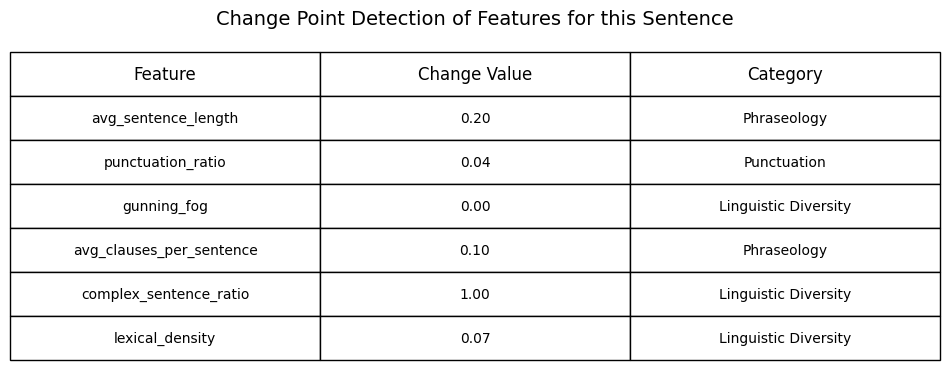

Change detected in sentence: Rommel Marbil who served the Senate arrest warrant to Guo.
Feature changes:


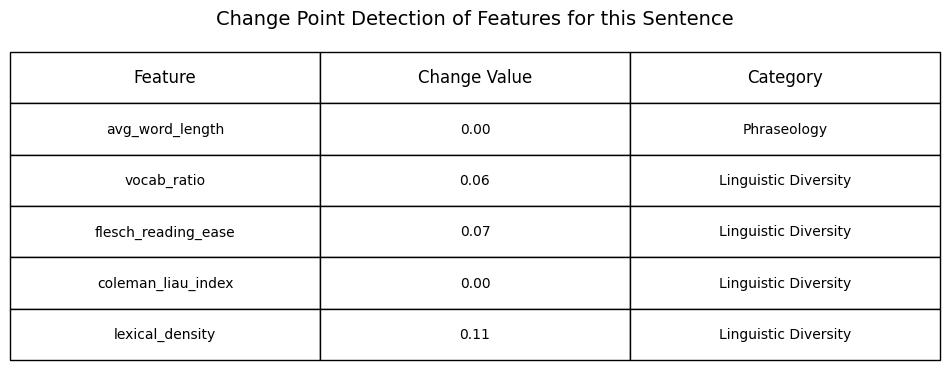

Change detected in sentence: She was brought back to Manila in yes, a private plane.
Feature changes:


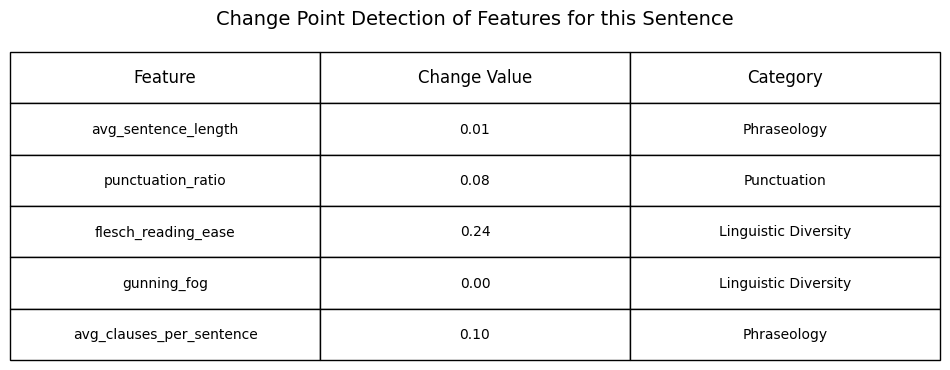

Change detected in sentence: There was little progress during the Senate hearing, notwithstanding the competent leadership of Senator Risa Hontiveros.
Feature changes:


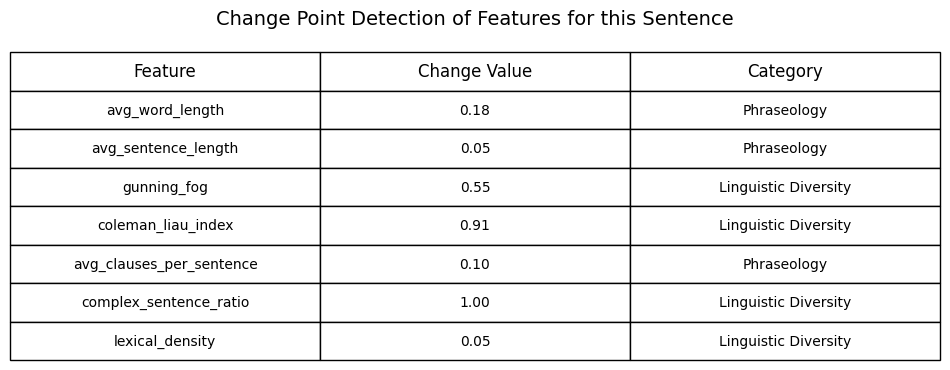

Change detected in sentence: We ourselves have nurtured such a habit of setting aside the law and just treating it as an elephant in the room, and in many cases, too, as a doormat.
Feature changes:


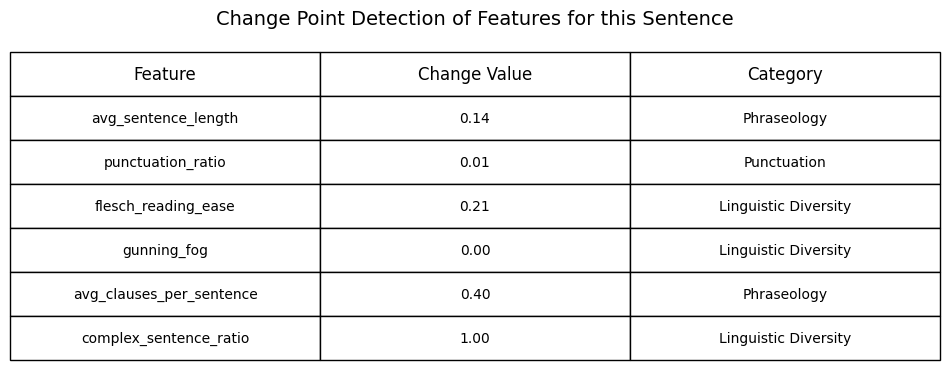

Change detected in sentence: This is in contrast to what the Philippines aspired for a “people-centered, clean and efficient governance” in the Philippine Development Plan 2017-2022.
Feature changes:


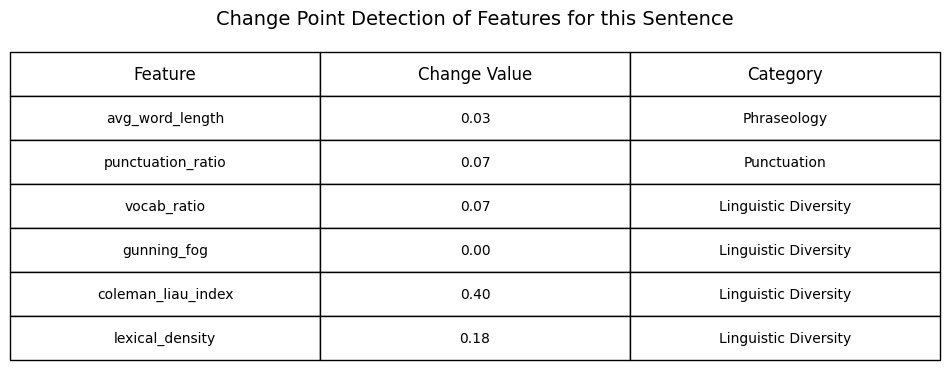

Change detected in sentence: In Chapter 5, we as a people, expressed our adherence to a high-trust society where “citizens obey the law, they willingly pay the correct taxes trusting that government will prudently manage the fiscal resources.” 

Indeed, the cornerstone of a high-trust society is the trust in government.
Feature changes:


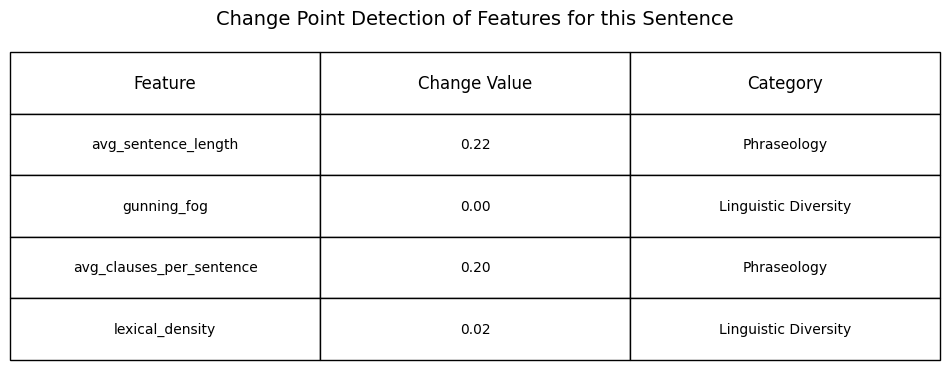

Change detected in sentence: But we have doubt whether the plan to “enhance the social fabric by making government worthy of people’s trust” actually bore fruit given Alice’s tale in POGO land.
Feature changes:


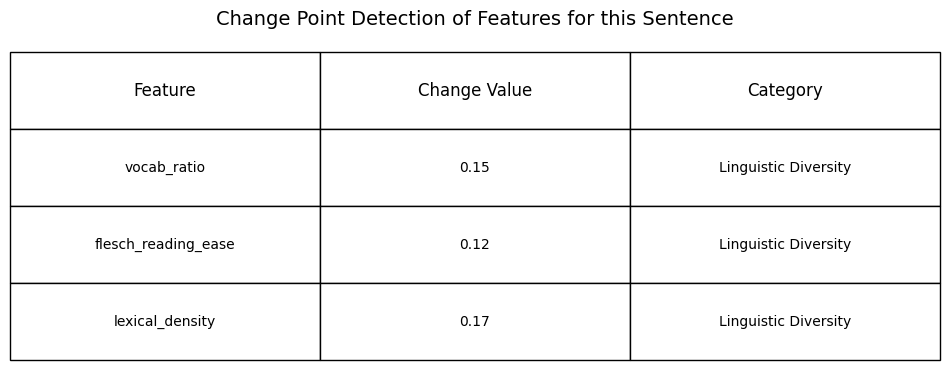


Changepoint Detection DataFrame:


,Sentence Index,Sentence,Feature,Change Value,Category
0,3,"If true, being non-Filipino made it worse, man...",punctuation_ratio,0.326797,Punctuation
1,3,"If true, being non-Filipino made it worse, man...",vocab_ratio,0.176471,Linguistic Diversity
2,3,"If true, being non-Filipino made it worse, man...",flesch_reading_ease,7.110000,Linguistic Diversity
3,3,"If true, being non-Filipino made it worse, man...",coleman_liau_index,2.640000,Linguistic Diversity
4,3,"If true, being non-Filipino made it worse, man...",avg_clauses_per_sentence,1.000000,Phraseology
...,...,...,...,...,...
93,41,"In Chapter 5, we as a people, expressed our ad...",avg_clauses_per_sentence,2.000000,Phraseology
94,41,"In Chapter 5, we as a people, expressed our ad...",lexical_density,0.016667,Linguistic Diversity
95,42,But we have doubt whether the plan to “enhance...,vocab_ratio,0.147619,Linguistic Diversity
96,42,But we have doubt whether the plan to “enhance...,flesch_reading_ease,11.850000,Linguistic Diversity



--- Detailed Explanations of Changepoints ---
Change detected in sentence: If true, being non-Filipino made it worse, many times over.
Feature changes:
  Feature: punctuation_ratio, Change Value: 0.3268, Category: Punctuation
  Feature: vocab_ratio, Change Value: 0.1765, Category: Linguistic Diversity
  Feature: flesch_reading_ease, Change Value: 0.0711, Category: Linguistic Diversity
  Feature: coleman_liau_index, Change Value: 0.0000, Category: Linguistic Diversity
  Feature: avg_clauses_per_sentence, Change Value: 0.1000, Category: Phraseology
  Feature: complex_sentence_ratio, Change Value: 1.0000, Category: Linguistic Diversity
  Feature: lexical_density, Change Value: 0.1895, Category: Linguistic Diversity

--------------------------------------------------------------------------------

Change detected in sentence: Of course, no less disrespectful of the law is how Apollo Quiboloy broke it by refusing to surrender to the authorities, until recently, despite the arrest warrant s

In [18]:
new_text = """Disrespecting the law is no less than an act of insolence, and in the “Law Insider” formulation, that is arrogant, presumptuous, impudent, or in fact even insulting. It could even be at once rude because it is no less than the Philippine law that is being crushed. 

What Alice Guo did was a shameless disregard of the law, call it contempt of the law. If true, being non-Filipino made it worse, many times over. Of course, no less disrespectful of the law is how Apollo Quiboloy broke it by refusing to surrender to the authorities, until recently, despite the arrest warrant served to him in his own kingdom. 

Unfortunately, disrespect of the law, rather than the rule of law, has a long history in the Philippines.

The American expatriate businessman Harry Stonehill broke the law when he bribed high-level government officials in the early 1960s. His case also dragged at least three former presidents in order to protect his $50 million business in tobacco and various commercial crops, among others. Then Justice Secretary Jose W. Diokno caused the raid of the offices of 42 of Stonehill’s business establishments in 1962 and the arrest of Stonehill and some of his associates. 

Based on what was described as six army trucks worth of incriminating evidence, Stonehill was accused of tax evasion, economic sabotage, and various other charges that could have been established by his Blue Book which mysteriously went missing. It contained the names of Filipino politicians and government officials who were alleged to have received bribe money from the American businessman. Before the case could be tried in court, Stonehill was subsequently deported by Malacañang.

Alice Guo treated Philippine law like rag when all evidence points to her faking her birth circumstances to gain entry into the Philippines and become a Filipino citizen. If she is indeed non-Filipino and therefore disqualified, she violated our electoral law when she ran and took her oath of office as mayor of Bamban, Tarlac. This gains credence in the face of Guo’s fingerprints being a perfect match with a Chinese national, Guo Hua Ping. Guo could not explain how she was able to construct the multibillion building complex of POGO business in Tarlac. It was impossible because her tax returns and SALN could only support a modest lifestyle.

As Reuters reported, even as Philippine authorities had filed several counts of money laundering, Guo continues to insist “she is natural-born Philippine citizen facing ‘malicious accusations,’ and had no knowledge of criminality.” This is strange because she could not even remember her roots, even her playmates while growing up.

For weeks before she escaped from the Philippines to Malaysia, Singapore and Indonesia, our elected senators could not get through her. It was a blank wall for them when Guo would always retort that she grew up in a farm, her only close friends were the farmhands in their piggery, or when confronted by documentary evidence of her true nationality, that she could not remember anymore. 

The bigger picture is the undeniable involvement of those in authority. 

She could not have entered the Philippines without the complicity of our immigration authorities. She could not have produced her Filipino birth certificate without the knowledge of the civil registrar and the statistics authorities. She could not have run for public office if our election authorities conducted a simple due diligence. She could not have sustained her POGO and alleged illegal activities if law enforcers did not turn a blind eye. She could not have escaped from the Philippines in July without official intervention. 

It's a sad commentary that even notarization of public documents could be dragged into this scandal. As Rappler reported, a lawyer “committed lapses when he notarized the counter-affidavit of suspended Bamban Mayor Alice Guo in relation to a DOJ human trafficking complaint on Aug. 14.” By that time, Guo was already out of the country. 

When she was finally arrested by Indonesian Interpol in Tangerang, it was disclosed that a Singaporean national helped Guo book four hotel rooms in Batam island. And to the surprise of many, no less than Interior Secretary Benhur Abalos and PNP Chief PGen. Rommel Marbil who served the Senate arrest warrant to Guo. She was brought back to Manila in yes, a private plane. 

There was little progress during the Senate hearing, notwithstanding the competent leadership of Senator Risa Hontiveros. All that Guo had to do to frustrate the senators’ spirited questioning was to claim innocence, short memory or the risk of incriminating herself. 

If at all, Guo even taught the Senate what to do and this was to convert the public hearing into an executive session. Only then could she disclose to the Senate who engineered her escape. When the Senate refused, Guo was persuaded to write on a piece of paper the name of the person who helped her escape. By the disclosure of two senators, another non-Filipino disregarded the Senate arrest warrant by helping Guo and her siblings and associates avoid arrest through the southern backdoor. 

Nothing should surprise us anymore when non-Filipinos have the gall to disrespect our legal and justice system. We ourselves have nurtured such a habit of setting aside the law and just treating it as an elephant in the room, and in many cases, too, as a doormat.

This is in contrast to what the Philippines aspired for a “people-centered, clean and efficient governance” in the Philippine Development Plan 2017-2022. In Chapter 5, we as a people, expressed our adherence to a high-trust society where “citizens obey the law, they willingly pay the correct taxes trusting that government will prudently manage the fiscal resources.” 

Indeed, the cornerstone of a high-trust society is the trust in government. 

But we have doubt whether the plan to “enhance the social fabric by making government worthy of people’s trust” actually bore fruit given Alice’s tale in POGO land."""
author = "Diwa C. Guinigundo"
#thresholds = [0.5, 5, 0.02, 0.05, 5, 2, 1, 2]
# predicted_author = classify_new_text(new_text, clf)

# print(f"The predicted author is: {predicted_author}")
#changepoints, explanations = detect_change_points_in_text(new_text, author, clf)

# Detect changepoints, explanations, and changepoint DataFrame
changepoints, explanations, changepoint_df = detect_change_points_in_text(new_text, author, clf)

# Display options for pandas to prevent compression issues
pd.set_option('display.max_rows', 20)  # Show up to 20 rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust column width

# Display the changepoint DataFrame
print("\nChangepoint Detection DataFrame:")
display(changepoint_df)

# Display the same results as before using explanations
print("\n--- Detailed Explanations of Changepoints ---")
for explanation in explanations:
    print(f"Change detected in sentence: {explanation['sentence']}")
    print("Feature changes:")
    for feature_change in explanation['feature_changes']:
        print(f"  Feature: {feature_change['Feature']}, Change Value: {feature_change['Change Value']:.4f}, Category: {feature_change['Category']}")
    print("\n" + "-" * 80 + "\n")  # Add a separator line and a blank line